In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
def evaluateSimulation(traj):
    model = search.getModelFromTraj(traj)
    model.randomICs()
    defaultDuration = model.params['duration']
      
    model.params['duration'] = defaultDuration
    
    rect_stimulus = stim.RectifiedInput(amplitude=0.4).to_model(model)
    exc_ext =  model.params['exc_ext']
    #print("e ext, I ext = ", model.params.exc_ext, model.params.inh_ext)
    
    model.params['exc_ext'] = rect_stimulus * 5.0 + exc_ext
    model.run()

    #plt.plot(model.t, model.exc[0,:])
    #plt.show()
    
    state_length = 2000
    down_window = (defaultDuration/2-state_length<model.t) & (model.t<defaultDuration/2)
    up_window = (defaultDuration-state_length<model.t) & (model.t<defaultDuration)
    up_state_rate = np.mean(model.output[:, up_window], axis=1)
    down_state_rate = np.mean(model.output[:, down_window], axis=1)
    up_down_difference = np.max(up_state_rate - down_state_rate)
        
    max_amp_output = np.max(
          np.max(model.output[:, up_window], axis=1) 
        - np.min(model.output[:, up_window], axis=1)
    )
    max_output = np.max(model.output[:, up_window])
     
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output, dt=model.params.dt, maxfr=40, spectrum_windowsize=10)
    max_power = np.max(model_pwrs)     
    
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output[:, up_window], dt=model.params.dt, maxfr=40, spectrum_windowsize=5)
    domfr = model_frs[np.argmax(model_pwrs)]    

    result = {
        "end" : 3,
        "max_output": max_output, 
        "max_amp_output" : max_amp_output,
        "max_power" : max_power,
        "domfr" : domfr,
        "up_down_difference" : up_down_difference
    }
    
    search.saveToPypet(result, traj)
    return 

In [3]:
model = WCModel()

model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 20 * 1000 # Simulation time, ms
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["exc_ext"] = 0.
model.params["inh_ext"] = 0.

In [4]:
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.parameterSpace import ParameterSpace
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func
import neurolib.optimize.exploration.explorationUtils as eu

parameters = ParameterSpace({"exc_ext": np.linspace(0.0, 4.0, 21), 
                             "inh_ext": np.linspace(0., 3., 16)
                             }, kind="grid")

search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='wc-bifurcation-diagram.hdf')

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/wc-bifurcation-diagram.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 336
MainProcess root INFO     BoxSearch: Environment initialized.


In [5]:
search.run()
search.loadResults(all=False)

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-02-13-08H-14M-32S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-02-13-08H-14M-32S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-02-13-08H-14M-32S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-02-13-08H-14M-32S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [6]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/wc-bifurcation-diagram.hdf
MainProcess root INFO     Analyzing trajectory results-2023-02-13-08H-14M-32S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/wc-bifurcation-diagram.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2023-02-13-08H-14M-32S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 336/336 [00:02<00:00, 125.94it/s]
MainProcess root INFO     All results loaded.


In [7]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5]]

/home/lena/Promotion/neurolib/neurolib/optimize/exploration/explorationUtils.py:269: UserWarning: No contour levels were found within the data range.
  contours = ax.contour(


[1.0, 0.5]
[2.8, 1.6]
[3.0, 0.5]


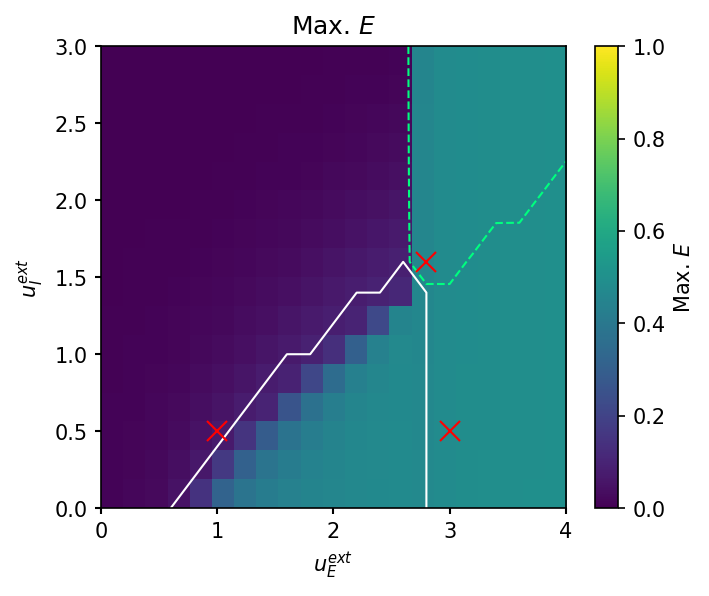

In [8]:
plot_key_label = "Max. $E$"
eu.plotExplorationResults(search.dfResults, 
                          par1=['exc_ext', '$u_E^{ext}$'], 
                          par2=['inh_ext', '$u_I^{ext}$'], 
                          plot_key='max_output',
                          plot_clim=[0.0, 1.0],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          contour=["max_amp_output", "up_down_difference"],
                          contour_color=[['white'], ['springgreen']],
                          contour_levels=[[10], [0.1]],
                          contour_alpha=[1.0, 1.0],
                          contour_kwargs={0 : {"linewidths" : (1,)}, 1 : {"linestyles" : "--", "linewidths" : (1,)}},
                          mask_threshold=0.1,
                          mask_alpha=0.2,
                          points=comp_points,
                          )

MainProcess root INFO     wc: Model initialized.


oscillation period =  15.7


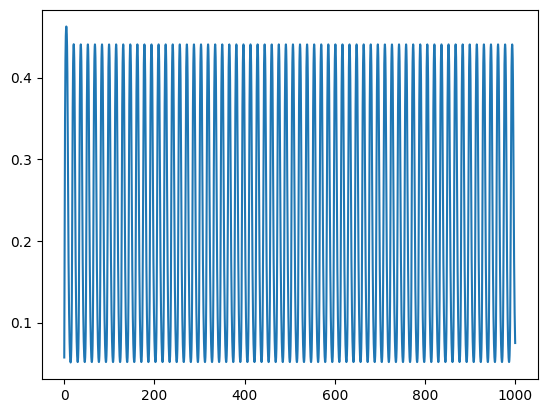

In [141]:
model = WCModel()

model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5

model.run()
plt.plot(model.t, model.exc[0,:])
peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),1)
print("oscillation period = ", period)

In [142]:
### point[0]
print("Point = ", comp_points[0])

duration = 200.
model.params.duration = duration
zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
model.params["exc_ext"] = zero_input + comp_points[0][0]
model.params["inh_ext"] = zero_input + comp_points[0][1]
model.run()
model.params.exc_init = np.array([[ model.exc[0,-1] ]])
model.params.inh_init = np.array([[ model.inh[0,-1] ]])
controlmat = np.ones((1,2))

Point =  [1.0, 0.5]


# Fourier cost

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.918225684508997e-13
Converged in iteration 5 with cost -6.100863365083254e-05
Final cost : -6.100863365083254e-05


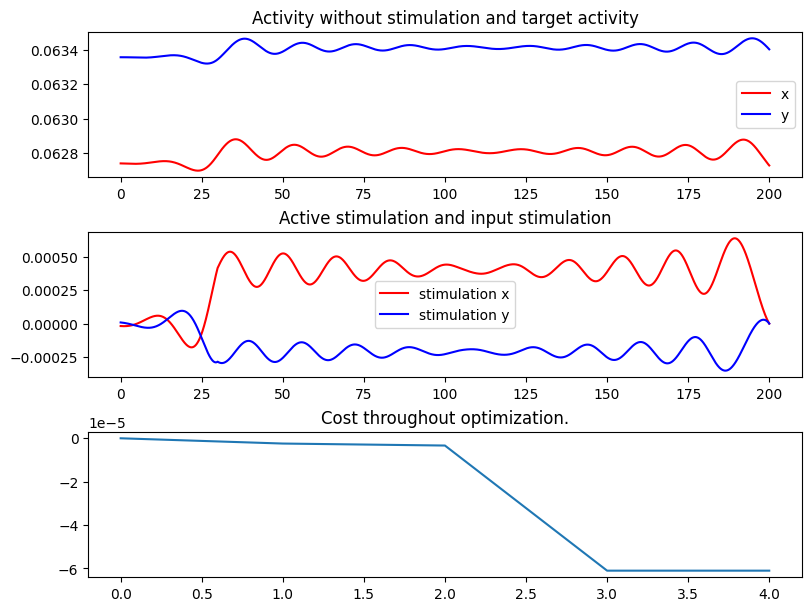

In [143]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_f"] = 1.
model_controlled.weights["w_2"] = 1e0

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.918225684508997e-13
Cost in iteration 5: -0.21367516190613842
Converged in iteration 7 with cost -0.21367516190613842
Final cost : -0.21367516190613842


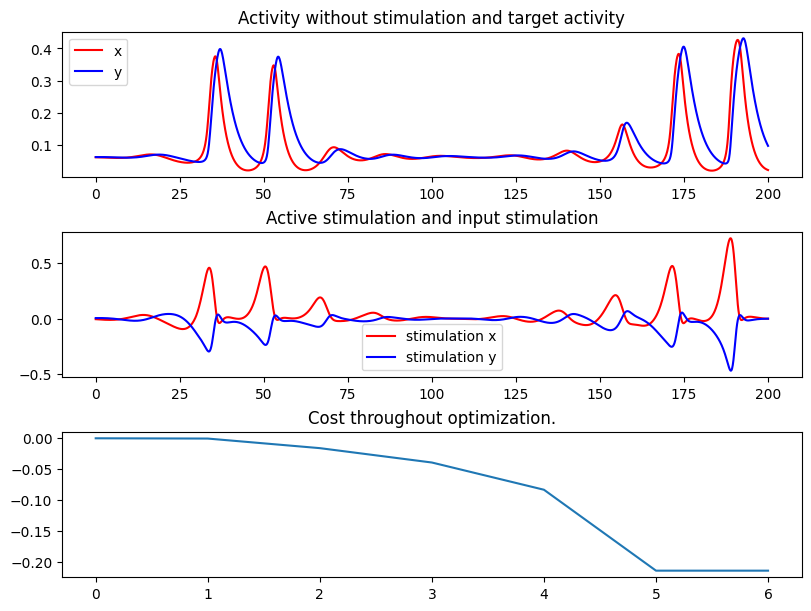

In [144]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_f"] = 1.
model_controlled.weights["w_2"] = 1e-2

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.918225684508997e-13
Cost in iteration 5: -0.4553796582683118
Cost in iteration 10: -0.55413793388448
Cost in iteration 15: -0.56128262851114
Converged in iteration 16 with cost -0.56128262851114
Final cost : -0.56128262851114


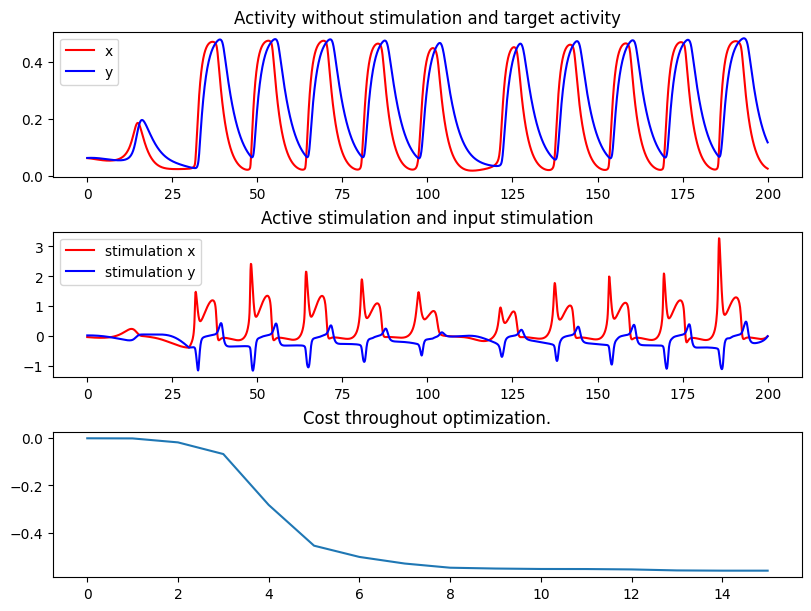

In [145]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_f"] = 1.
model_controlled.weights["w_2"] = 1e-4

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2.918225684508997e-13
Cost in iteration 5: -0.45903921799177255
Cost in iteration 10: -0.5877717248322577
Cost in iteration 15: -0.6088086116111167
Cost in iteration 20: -0.609250445698236
Converged in iteration 23 with cost -0.6093809135005742
Final cost : -0.6093809135005742


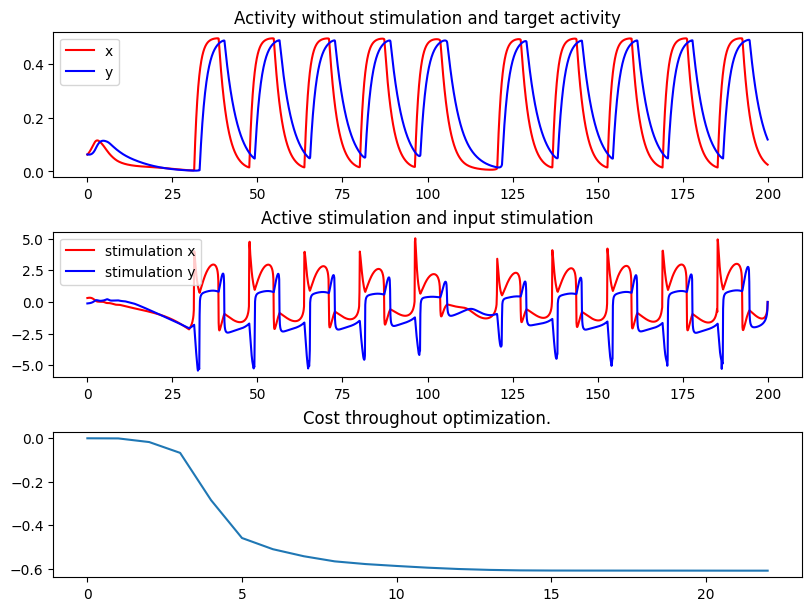

In [146]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_f"] = 1.
model_controlled.weights["w_2"] = 1e-6

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)
c_res = model_controlled.control.copy()

# Phase cost

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 72.2776385795685
Cost in iteration 5: -1759.1886829648947
Converged in iteration 9 with cost -1761.415967338295
Final cost : -1761.415967338295


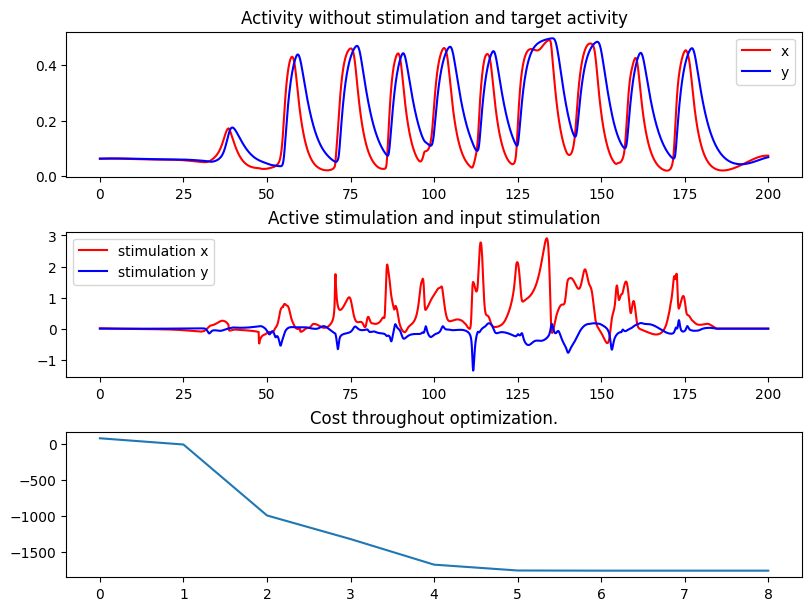

In [147]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_phase"] = 1.
model_controlled.weights["w_2"] = 1e0

c_input = c_res.copy()
c_input[0,1,:] = 0.
c_input[0,0,600:] = 0.

model_controlled.control = c_input
model_controlled.update_input()
model_controlled.optimize(100)

plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.7227763857956857
Cost in iteration 5: -1267.9794435736558
Cost in iteration 10: -1284.9044212708968
Cost in iteration 15: -1284.9046875816944
Cost in iteration 20: -1284.904687784256
Cost in iteration 25: -1284.9046877845726
Cost in iteration 30: -1284.9046877845813
Converged in iteration 33 with cost -1284.9046877845813
Final cost : -1284.9046877845813


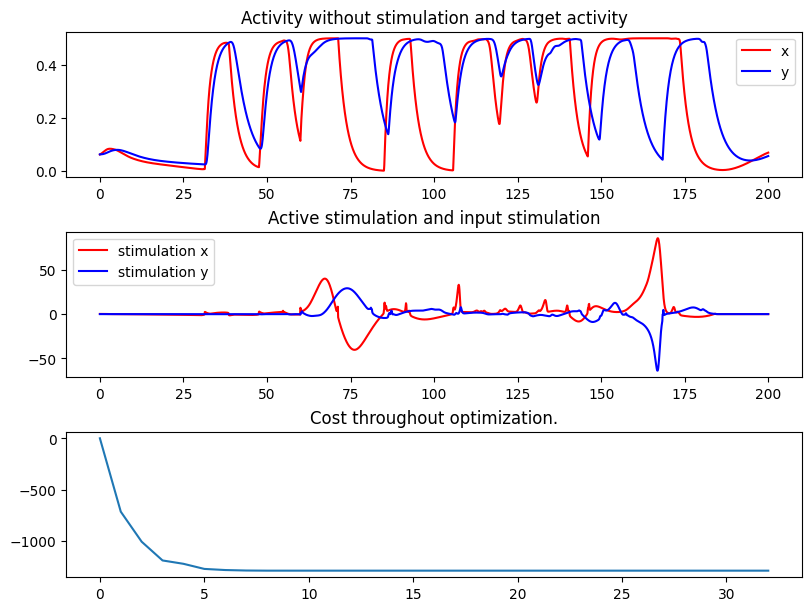

In [148]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_phase"] = 1.
model_controlled.weights["w_2"] = 1e-2

model_controlled.control = c_input
model_controlled.update_input()
model_controlled.optimize(100)

plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)

# Auto correlation cost

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.0036432607727189e-26
Cost in iteration 5: -3.9903321504278407e-26
Converged in iteration 8 with cost -3.9906814270483054e-26
Final cost : -3.9906814270483054e-26


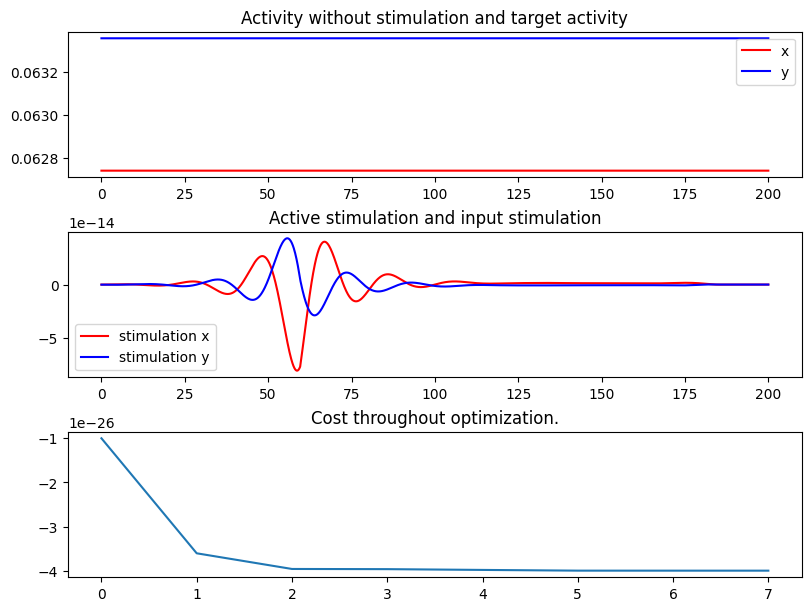

In [149]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_ac"] = 1.
model_controlled.weights["w_2"] = 1e0

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)
c_res = model_controlled.control.copy()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.0036432607727189e-26
Cost in iteration 5: -8.963275266163958e-18
Cost in iteration 10: -5.49751969906842e-11
Cost in iteration 15: -0.04258088928520767
Cost in iteration 20: -6.04053076156952
Cost in iteration 25: -9.248674537086673
Cost in iteration 30: -11.081651501769034
Converged in iteration 35 with cost -11.207864779582795
Final cost : -11.207864779582795


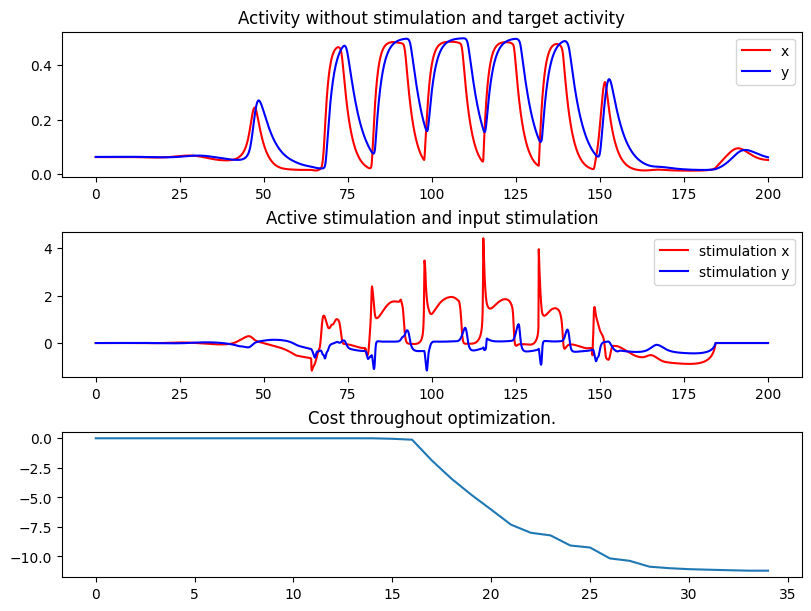

In [150]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_ac"] = 1.
model_controlled.weights["w_2"] = 1e-2

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)
c_res = model_controlled.control.copy()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.0036432607727189e-26
Cost in iteration 5: -1.5724022003683612e-15
Cost in iteration 10: -0.005838733205647089
Cost in iteration 15: -9.127728652176934
Cost in iteration 20: -12.736052420145654
Cost in iteration 25: -14.307936643471852
Cost in iteration 30: -14.880763763927908
Converged in iteration 32 with cost -14.880763763927908
Final cost : -14.880763763927908


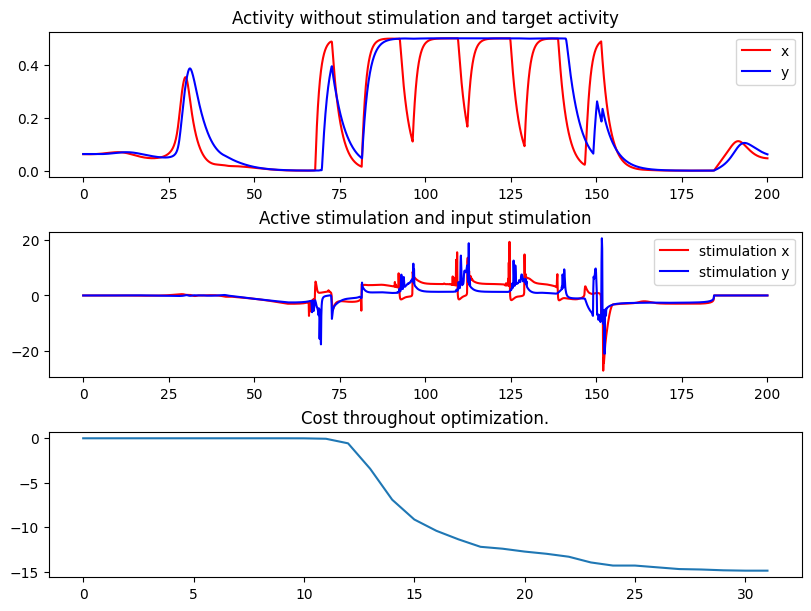

In [151]:
model_controlled = oc_wc.OcWc(model, period, print_array=np.arange(0,101,5), cost_interval=(300,None), control_matrix = controlmat, )
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_ac"] = 1.
model_controlled.weights["w_2"] = 1e-4

model_controlled.optimize(100)
plot_oc_singlenode(duration, model.params.dt, model_controlled.get_xs(), period, model_controlled.control, cost_array=model_controlled.cost_history)
c_res = model_controlled.control.copy()